In [79]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.utils.data
import math
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import uuid
import time
from tqdm import tqdm
from dtaidistance import dtw
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [80]:
# CARREGAR OS DADOS

def carregar_ecgs(unlabel, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, unlabel) if len(ecg_normal_id) >= unlabel else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X , ids_ecgs

In [81]:
import numpy as np

def get_my_dataset(X, unlabel=100,umdavb=100,rbbb=100,lbbb=100,sb=100,st=100,af=100,train_ratio=0.8):
    """
    Prepara o dataset de ECG para o treinamento.
    
    Parâmetros:
      - X: array de ECG (formato: [n_samples, n_channels, length])
      - os números de amostras por classe (deve coincidir com a ordem de concatenação na função carregar_ecgs)
      - train_ratio: proporção dos dados para treinamento
      
    Retorna:
      - X (possivelmente normalizado),
      - y: vetor de labels (0: normal, 1: umdavb, 2: rbbb, 3: lbbb, 4: sb, 5: st, 6: af)
      - train_idx: índices de treinamento
      - test_idx: índices de teste
    """
    
    total_samples = unlabel + umdavb + rbbb + lbbb + sb + st + af
    if X.shape[0] != total_samples:
        raise ValueError(f"O número de traçados em X ({X.shape[0]}) não corresponde à soma esperada ({total_samples}).")
    
    # Cria os labels de acordo com a ordem de concatenação
    y = np.array([0]*unlabel + 
                 [1]*umdavb + 
                 [2]*rbbb + 
                 [3]*lbbb + 
                 [4]*sb + 
                 [5]*st + 
                 [6]*af)
    
    # Aqui assumimos que a normalização é feita sobre o último eixo (tempo)
    X_norm = X.copy().astype(np.float32)
    for i in range(X_norm.shape[0]):
        # Evita divisão por zero
        mean_val = X_norm[i].mean()
        std_val = X_norm[i].std() if X_norm[i].std() != 0 else 1.0
        X_norm[i] = (X_norm[i] - mean_val) / std_val
    
    # Cria a divisão em treinamento e teste (shuffle dos índices)
    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    split = int(train_ratio * total_samples)
    train_idx = indices[:split]
    test_idx = indices[split:]
    
    return X_norm, y, train_idx, test_idx


In [82]:
import os
import uuid
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.utils.data
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

class SimTSCTrainer:
    def __init__(self, device, logger):
        """
        device: typically torch.device("cuda" or "cpu")
        logger: an object with a .log() method to print/save logs
        """
        self.device = device
        self.logger = logger
        
        self.tmp_dir = 'tmp'
        if not os.path.exists(self.tmp_dir):
            os.makedirs(self.tmp_dir)

    def fit(self, model, X, y, train_idx, distances, K, alpha,
            test_idx=None, report_test=False, batch_size=128, epochs=50):
        """
        Train the SimTSC model.
          - model: instance of SimTSC
          - X, y: dataset and labels (torch or np arrays)
          - train_idx: training indices
          - distances: distance matrix
          - K, alpha: hyperparameters for building the adjacency
          - test_idx: testing indices (optional)
          - report_test: if True, it logs test performance each epoch
          - batch_size: batch size (will be split into main batch + other)
          - epochs: number of training epochs
        """
        self.K = K
        self.alpha = alpha

        # Convert X and y to Tensors
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X)
        if not isinstance(y, torch.Tensor):
            y = torch.from_numpy(y)
        self.X = X.to(self.device)
        self.y = y.to(self.device)

        # Convert distances to Tensor
        if not torch.is_tensor(distances):
            distances = torch.from_numpy(distances.astype(np.float32))
        self.adj = distances

        # Split batch into main + other
        train_batch_size = min(batch_size // 2, len(train_idx))
        other_idx = np.array([i for i in range(len(X)) if i not in train_idx])
        other_batch_size = min(batch_size - train_batch_size, len(other_idx))

        train_dataset = Dataset(train_idx)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=train_batch_size,
            shuffle=True,
            num_workers=1
        )

        if report_test and test_idx is not None:
            test_batch_size = min(batch_size // 2, len(test_idx))
            other_idx_test = np.array([i for i in range(len(X)) if i not in test_idx])
            other_batch_size_test = min(batch_size - test_batch_size, len(other_idx_test))
            test_dataset = Dataset(test_idx)
            test_loader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size=test_batch_size,
                shuffle=True,
                num_workers=1
            )
        else:
            test_loader = None
            other_idx_test = None
            other_batch_size_test = None

        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=4e-3)

        file_path = os.path.join(self.tmp_dir, str(uuid.uuid4()))
        best_acc = 0.0

        for epoch in range(epochs):
            model.train()
            epoch_losses = []
            for sampled_train_idx in train_loader:
                sampled_other_idx = np.random.choice(other_idx, other_batch_size, replace=False)
                idx = np.concatenate((sampled_train_idx, sampled_other_idx))
                _X = self.X[idx]
                _y = self.y[sampled_train_idx]
                _adj = self.adj[idx][:, idx].to(self.device)

                outputs = model(_X, _adj, K, alpha)
                loss = F.nll_loss(outputs[:len(sampled_train_idx)], _y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_losses.append(loss.item())

            # Evaluate on training data
            model.eval()
            acc = self._compute_accuracy(model, train_loader, other_idx, other_batch_size)
            mean_loss_epoch = np.mean(epoch_losses) if epoch_losses else 0.0

            # Check if it's the best so far
            if acc >= best_acc:
                best_acc = acc
                torch.save(model.state_dict(), file_path)

            # Optionally evaluate on test data
            if report_test and (test_loader is not None):
                test_acc = self._compute_accuracy(model, test_loader, other_idx_test, other_batch_size_test)
                self.logger.log(
                    f"[Epoch {epoch}] Train Loss: {mean_loss_epoch:.4f} | "
                    f"Train Acc: {acc:.4f} (Best: {best_acc:.4f}) | "
                    f"Test Acc: {test_acc:.4f}"
                )
            else:
                self.logger.log(
                    f"[Epoch {epoch}] Train Loss: {mean_loss_epoch:.4f} | "
                    f"Train Acc: {acc:.4f} (Best: {best_acc:.4f})"
                )

        # Load best checkpoint
        model.load_state_dict(torch.load(file_path))
        model.eval()
        os.remove(file_path)
        
        return model

    def _compute_accuracy(self, model, loader, other_idx, other_batch_size):
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx in loader:
                sampled_other_idx = np.random.choice(other_idx, other_batch_size, replace=False)
                combined_idx = np.concatenate((batch_idx, sampled_other_idx))
                _X = self.X[combined_idx]
                _y = self.y[batch_idx]
                _adj = self.adj[combined_idx][:, combined_idx].to(self.device)

                outputs = model(_X, _adj, self.K, self.alpha)
                main_outputs = outputs[:len(batch_idx)]
                preds = main_outputs.argmax(dim=1)
                correct += (preds == _y).sum().item()
                total += len(batch_idx)
        return correct / total if total > 0 else 0.0

    def test(self, model, test_idx, batch_size=128, class_names=None):
        """
        Test the model under the same subgraph scheme (batch + 'other'),
        computing Loss, Accuracy, F1, Precision, Recall, and AUC.
        Also plots the ROC curve for each class plus a macro-average.
        """
        if class_names is None:
            # If no class names are provided, generate generic names
            num_classes = len(torch.unique(self.y))
            class_names = [f"Class {i}" for i in range(num_classes)]
        else:
            num_classes = len(class_names)

        test_batch_size = min(batch_size // 2, len(test_idx))
        other_idx_test = np.array([i for i in range(len(self.X)) if i not in test_idx])
        other_batch_size_test = min(batch_size - test_batch_size, len(other_idx_test))

        test_dataset = Dataset(test_idx)
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=test_batch_size,
            shuffle=True,
            num_workers=1
        )

        total_loss = 0.0
        total_count = 0
        all_preds = []
        all_labels = []
        all_scores = []

        model.eval()
        with torch.no_grad():
            for batch_indices in test_loader:
                sampled_other_idx = np.random.choice(other_idx_test, other_batch_size_test, replace=False)
                combined_idx = np.concatenate((batch_indices, sampled_other_idx))

                _X = self.X[combined_idx]
                _adj = self.adj[combined_idx][:, combined_idx].to(self.device)

                outputs = model(_X, _adj, self.K, self.alpha)  # log-softmax
                main_outputs = outputs[:len(batch_indices)]
                main_labels = self.y[batch_indices]

                batch_loss = F.nll_loss(main_outputs, main_labels, reduction='sum')
                total_loss += batch_loss.item()
                total_count += len(batch_indices)

                preds = main_outputs.argmax(dim=1).cpu().numpy()
                probs = torch.exp(main_outputs).cpu().numpy()  # convert log-softmax -> probabilities

                all_preds.extend(preds)
                all_labels.extend(main_labels.cpu().numpy())
                all_scores.append(probs)

        mean_loss = total_loss / total_count if total_count > 0 else 0.0
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_scores = np.vstack(all_scores) if len(all_scores) > 0 else np.array([])

        accuracy = (all_preds == all_labels).sum() / total_count if total_count > 0 else 0.0
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        f1_per_class = f1_score(all_labels, all_preds, average=None)
        precision_macro = precision_score(all_labels, all_preds, average='macro')
        recall_macro = recall_score(all_labels, all_preds, average='macro')

        # AUC (one-vs-rest)
        all_labels_onehot = label_binarize(all_labels, classes=range(num_classes))
        if all_scores.shape[0] == 0:
            auc_macro = 0.0
        else:
            auc_macro = roc_auc_score(
                all_labels_onehot, all_scores,
                average='macro',
                multi_class='ovr'
            )

        self.logger.log(
            f"[TEST] Loss: {mean_loss:.4f} | Acc: {accuracy:.4f} | "
            f"F1(macro): {f1_macro:.4f} | Prec(macro): {precision_macro:.4f} | "
            f"Recall(macro): {recall_macro:.4f} | AUC(macro): {auc_macro:.4f}"
        )

        # Plot ROC for each class
        if all_scores.shape[0] > 0:
            fpr_dict = {}
            tpr_dict = {}
            roc_auc_dict = {}

            for i in range(num_classes):
                fpr_dict[i], tpr_dict[i], _ = roc_curve(all_labels_onehot[:, i], all_scores[:, i])
                roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

            # Macro-average curve
            all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(num_classes):
                mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
            mean_tpr /= num_classes
            macro_auc_curve = auc(all_fpr, mean_tpr)

            plt.figure()
            for i in range(num_classes):
                plt.plot(
                    fpr_dict[i],
                    tpr_dict[i],
                    label=f"{class_names[i]} (AUC = {roc_auc_dict[i]:.2f})"
                )
            plt.plot(all_fpr, mean_tpr,
                     label=f"Macro-average (AUC = {macro_auc_curve:.2f})",
                     linestyle='--')

            plt.xlabel("False Positive Rate (FPR)")
            plt.ylabel("True Positive Rate (TPR)")
            plt.title("Multiclass ROC Curves")
            plt.legend(loc="lower right")
            plt.show()

        return {
            'loss': mean_loss,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'auc_macro': auc_macro
        }



class SimTSC(nn.Module):
    def __init__(self, input_size, nb_classes, num_layers=1, n_feature_maps=64, dropout=0.5):
        super(SimTSC, self).__init__()
        self.num_layers = num_layers
        self.block_1 = ResNetBlock(input_size, n_feature_maps)
        self.block_2 = ResNetBlock(n_feature_maps, n_feature_maps)
        self.block_3 = ResNetBlock(n_feature_maps, n_feature_maps)
        if self.num_layers == 1:
            self.gc1 = GraphConvolution(n_feature_maps, nb_classes)
        elif self.num_layers == 2:
            self.gc1 = GraphConvolution(n_feature_maps, n_feature_maps)
            self.gc2 = GraphConvolution(n_feature_maps, nb_classes)
            self.dropout = dropout
        elif self.num_layers == 3:
            self.gc1 = GraphConvolution(n_feature_maps, n_feature_maps)
            self.gc2 = GraphConvolution(n_feature_maps, n_feature_maps)
            self.gc3 = GraphConvolution(n_feature_maps, nb_classes)
            self.dropout = dropout

    def forward(self, x, adj, K, alpha):
        ranks = torch.argsort(adj, dim=1)
        sparse_index = [[], []]
        sparse_value = []
        for i in range(len(adj)):
            _sparse_value = []
            for j in ranks[i][:K]:
                sparse_index[0].append(i)
                sparse_index[1].append(j)
                _sparse_value.append(1/np.exp(alpha * adj[i][j].cpu().item()))
            _sparse_value = np.array(_sparse_value)
            _sparse_value /= _sparse_value.sum()
            sparse_value.extend(_sparse_value.tolist())
        sparse_index = torch.LongTensor(sparse_index)
        sparse_value = torch.FloatTensor(sparse_value)
        adj = torch.sparse.FloatTensor(sparse_index, sparse_value, adj.size())
        device = self.gc1.bias.device
        adj = adj.to(device)

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = F.avg_pool1d(x, x.shape[-1]).squeeze()

        if self.num_layers == 1:
            x = self.gc1(x, adj)
        elif self.num_layers == 2:
            x = F.relu(self.gc1(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            x = self.gc2(x, adj)
        elif self.num_layers == 3:
            x = F.relu(self.gc1(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            x = F.relu(self.gc2(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            x = self.gc3(x, adj)

        x = F.log_softmax(x, dim=1)
        return x

class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.expand = True if in_channels < out_channels else False
        self.conv_x = nn.Conv1d(in_channels, out_channels, 7, padding=3)
        self.bn_x = nn.BatchNorm1d(out_channels)
        self.conv_y = nn.Conv1d(out_channels, out_channels, 5, padding=2)
        self.bn_y = nn.BatchNorm1d(out_channels)
        self.conv_z = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn_z = nn.BatchNorm1d(out_channels)
        if self.expand:
            self.shortcut_y = nn.Conv1d(in_channels, out_channels, 1)
        self.bn_shortcut_y = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn_x(self.conv_x(x)))
        out = F.relu(self.bn_y(self.conv_y(out)))
        out = self.bn_z(self.conv_z(out))
        if self.expand:
            x = self.shortcut_y(x)
        x = self.bn_shortcut_y(x)
        out += x
        out = F.relu(out)
        return out

class Dataset(torch.utils.data.Dataset):
    def __init__(self, idx):
        self.idx = idx

    def __getitem__(self, index):
        return self.idx[index]

    def __len__(self):
        return len(self.idx)


In [ ]:
# 1) Carregar e preparar dados
X, ids_ecgs = carregar_ecgs(
    unlabel=15000, umdavb=2500, rbbb=2500,
    lbbb=2500, sb=2500, st=2500, af=2500,
    filtrado=True
)

# Aqui fazemos a separação e normalização (exemplo com 80% train, 20% test)
X_norm, y, train_idx, test_idx = get_my_dataset(
    X, 
    unlabel=15000, umdavb=2500, rbbb=2500,
    lbbb=2500, sb=2500, st=2500, af=2500,
    train_ratio=0.8
)
print("X_norm shape:", X_norm.shape)
print("Tamanho do y:", len(y))
print("Número de amostras em train_idx:", len(train_idx))
print("Número de amostras em test_idx:", len(test_idx))

Número de linhas ecg_normal_linhas: 272407
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 252167
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 700
Número de ecgs que eram pra ser processados: 700
Número total de traçados processados: 700
X_norm shape: (700, 12, 4096)
Tamanho do y: 700
Número de amostras em train_idx: 560
Número de amostras em test_idx: 140


In [84]:
import os
import numpy as np
import torch
import time
import sys
from tqdm import tqdm
from dtaidistance import dtw
from joblib import Parallel, delayed
import torch
import numpy as np
from sklearn.metrics import f1_score
import torch.nn.functional as F



# 2) Calcular a matriz de distâncias DTW (ou outra distância)
def process_i(i, X_single, n_samples, r):
    """
    Processa a linha i da matriz de distâncias DTW de forma paralela.
    """
    local_row = np.ascontiguousarray(X_single[i], dtype=np.float64).copy()
    local_row.setflags(write=True)  # Garante que é mutável
    
    dists = []
    for j in range(i, n_samples):
        target = np.ascontiguousarray(X_single[j], dtype=np.float64).copy()
        target.setflags(write=True)  # Garante que é mutável
        
        dist = dtw.distance_fast(local_row, target, window=r)
        dists.append(dist)
    
    return i, dists

def get_dtw_for_ecg_parallel(X, r=100, n_jobs=-1):
    """
    Calcula a matriz de distâncias DTW usando paralelismo para acelerar a computação.
    
    Parâmetros:
        X (numpy array): Dados de entrada (shape: [n amostras, canais, comprimento da série]).
        r (int): Janela de restrição para o cálculo DTW.
        n_jobs (int): Número de núcleos para paralelismo (-1 usa todos disponíveis).
    
    Retorna:
        distances (numpy array): Matriz de distâncias DTW simétrica.
    """
    # Garante que os dados estão no formato correto e mutáveis
    X_single = np.asarray(X[:, 0, :], dtype=np.float64).copy()
    X_single.setflags(write=True)
    
    n_samples = X_single.shape[0]
    distances = np.zeros((n_samples, n_samples), dtype=np.float64)

    print("Calculando matriz DTW com paralelismo...")
    start_time = time.time()

    # Inicializa a barra de progresso
    with tqdm(total=n_samples, desc="Calculando DTW", unit="linha") as pbar:
        results = Parallel(n_jobs=n_jobs, backend="loky", return_as="generator")(
            delayed(process_i)(i, X_single, n_samples, r) 
            for i in range(n_samples)
        )

        # Atualiza a barra de progresso enquanto preenche a matriz
        for i, dists in results:
            j_indices = np.arange(i, n_samples)
            distances[i, j_indices] = dists
            distances[j_indices, i] = dists  # Garante simetria
            pbar.update(1)  # Atualiza a barra de progresso após cada linha processada

    elapsed_time = time.time() - start_time
    print(f"\nCálculo DTW finalizado em {elapsed_time / 60:.2f} minutos.")

    return distances
distances = get_dtw_for_ecg_parallel(X_norm, r=100, n_jobs=-1)
np.save("distances_dtw.npy", distances)
print("Matriz de distâncias calculada com shape:", distances.shape)

Calculando matriz DTW com paralelismo...


Calculando DTW: 100%|██████████| 700/700 [00:30<00:00, 23.06linha/s] 


Cálculo DTW finalizado em 0.51 minutos.
Matriz de distâncias calculada com shape: (700, 700)


Using device: cuda
Starting training...
[Epoch 0] Train Loss: 1.8947 | Train Acc: 0.1286 (Best: 0.1286) | Test Acc: 0.1643
[Epoch 1] Train Loss: 1.7814 | Train Acc: 0.3143 (Best: 0.3143) | Test Acc: 0.3357
[Epoch 2] Train Loss: 1.6864 | Train Acc: 0.5304 (Best: 0.5304) | Test Acc: 0.4357
[Epoch 3] Train Loss: 1.5978 | Train Acc: 0.5536 (Best: 0.5536) | Test Acc: 0.4429
[Epoch 4] Train Loss: 1.5326 | Train Acc: 0.5429 (Best: 0.5536) | Test Acc: 0.4643
[Epoch 5] Train Loss: 1.4728 | Train Acc: 0.5643 (Best: 0.5643) | Test Acc: 0.4571
[Epoch 6] Train Loss: 1.4234 | Train Acc: 0.5946 (Best: 0.5946) | Test Acc: 0.4857
[Epoch 7] Train Loss: 1.3862 | Train Acc: 0.6000 (Best: 0.6000) | Test Acc: 0.4786
[Epoch 8] Train Loss: 1.3416 | Train Acc: 0.6089 (Best: 0.6089) | Test Acc: 0.4571
[Epoch 9] Train Loss: 1.3067 | Train Acc: 0.6321 (Best: 0.6321) | Test Acc: 0.5000
[Epoch 10] Train Loss: 1.2725 | Train Acc: 0.6268 (Best: 0.6321) | Test Acc: 0.5071
[Epoch 11] Train Loss: 1.2522 | Train Acc: 0.6

/tmp/ipykernel_3911119/1280264960.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


[TEST] Loss: 1.3500 | Acc: 0.5571 | F1(macro): 0.5536 | Prec(macro): 0.6476 | Recall(macro): 0.5727 | AUC(macro): 0.8702


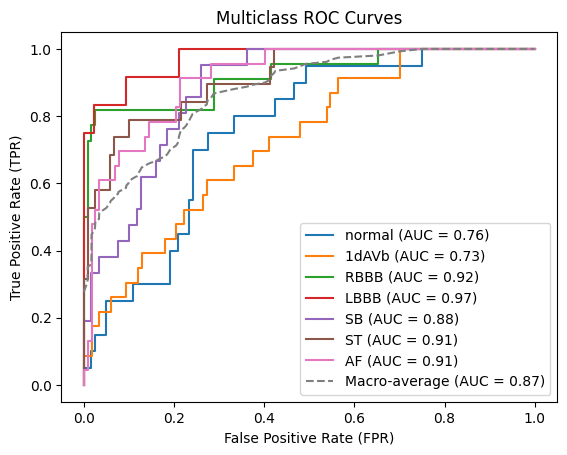


--- Final Results ---
loss: 1.3499550138201033
accuracy: 0.5571428571428572
f1_macro: 0.5536115467188109
f1_per_class: [0.3        0.23076923 0.82926829 0.86956522 0.48888889 0.51162791
 0.64516129]
precision_macro: 0.6476164186690502
recall_macro: 0.5726882140415974
auc_macro: 0.8702390343795872


In [85]:
# 3) Create the SimTSC model
num_classes = len(np.unique(y))  # Example: 7 classes
input_size = X_norm.shape[1]     # Number of channels after ResNet (?)
model = SimTSC(
    input_size=input_size,
    nb_classes=num_classes,
    num_layers=1,      # Example: 1 or 2 or 3
    n_feature_maps=64, # Can be adjusted
    dropout=0.5
)

# 4) Define the device and a logger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Using device:", device)

class Logger:
    def __init__(self, f):
        self.f = f
    def log(self, content):
        print(content)
        self.f.write(content + '\n')
        self.f.flush()

log_path = "./logs/simtsc_ecg_log.txt"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
f = open(log_path, 'w')
logger = Logger(f)

# 5) Create the trainer (updated version calculating loss in test)
trainer = SimTSCTrainer(device=device, logger=logger)

# 6) Train the model
K = 3
alpha = 0.3
epochs = 50  # Adjust as needed
print("Starting training...")

model = trainer.fit(
    model=model,
    X=X_norm,
    y=y,
    train_idx=train_idx,
    distances=distances,
    K=K,
    alpha=alpha,
    test_idx=test_idx,   # Monitor test performance during epochs
    report_test=True,    # Logs test results every epoch
    batch_size=128,
    epochs=epochs
)


# 7) Final evaluation on the test set
class_names = ["normal", "1dAVb", "RBBB", "LBBB", "SB", "ST", "AF"]
results = trainer.test(model, test_idx, batch_size=128, class_names=class_names)
print("\n--- Final Results ---")
for k, v in results.items():
    if isinstance(v, np.ndarray):
        print(f"{k}: {v}")
    else:
        print(f"{k}: {v}")

f.close()